In [10]:
%matplotlib inline

##Import Data

In [11]:
import epi_prediction
src_dir = '/Users/johnbonihalab/data/chuyu/modalities'
control_filter = lambda file_name: 'CON' in file_name
patient_filter = lambda file_name: 'PAT' in file_name

In [12]:
epi_paths = epi_prediction.get_epi_paths(src_dir, patient_filter, control_filter)

In [13]:
mod_paths = epi_paths['kmean']

In [14]:
mod_paths

cons    [/Users/johnbonihalab/data/chuyu/modalities/km...
pats    [/Users/johnbonihalab/data/chuyu/modalities/km...
Name: kmean, dtype: object

In [15]:
labels = len(mod_paths['pats']) * [1] + len(mod_paths['cons']) * [0]

In [16]:
len(labels)

68

##Load White Matter Mask

In [17]:
white_matter = epi_prediction.SimpleMasker('masks/white.nii', threshold=.2)

In [18]:
mat = white_matter.transform_many(mod_paths['pats'] + mod_paths['cons'], verbose=True)

--------------------------------------------------------------------
####################################################################

##Retrieve the Voxels

__Retrieving Important Voxels Requires Linear Classifier__

In [19]:
from nilearn.input_data import NiftiMasker
import numpy as np
from sklearn.cross_validation import StratifiedKFold, cross_val_score
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.grid_search import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC

In [20]:
n_folds = 6
svc = SVC()
anova_svc_lin = Pipeline( [('anova', SelectKBest(k=500)), ('svc', svc)] )
anova_svc_lin.set_params(svc__kernel='linear')
cv = StratifiedKFold(labels, n_folds=6)
labels_arr = np.array(labels)

In [21]:
C_range_lin = np.logspace(-3, 3, 7)
#k_range = np.linspace(500,2000,3).astype(int)
k_range=[500]

total_runs = len(C_range_lin) * n_folds

scorer = epi_prediction.verbose_scorer(total_runs)
grid_lin = GridSearchCV(anova_svc_lin, param_grid={"svc__C": C_range_lin,"anova__k" :k_range}, cv=cv, scoring = scorer)

grid_lin.fit(mat, labels_arr)

------------------------------------------
##########################################

//anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:958: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


GridSearchCV(cv=sklearn.cross_validation.StratifiedKFold(labels=[1 1 ..., 0 0], n_folds=6, shuffle=False, random_state=None),
       error_score='raise',
       estimator=Pipeline(steps=[('anova', SelectKBest(k=500, score_func=<function f_classif at 0x10c8a6e60>)), ('svc', SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0, degree=3, gamma=0.0,
  kernel='linear', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False))]),
       fit_params={}, iid=True, loss_func=None, n_jobs=1,
       param_grid={'anova__k': [500], 'svc__C': array([  1.00000e-03,   1.00000e-02,   1.00000e-01,   1.00000e+00,
         1.00000e+01,   1.00000e+02,   1.00000e+03])},
       pre_dispatch='2*n_jobs', refit=True, score_func=None,
       scoring=make_scorer(verbose_score_fn), verbose=0)

In [22]:
grid_lin.grid_scores_

[mean: 0.00000, std: 0.00000, params: {'anova__k': 500, 'svc__C': 0.001},
 mean: 0.68717, std: 0.19456, params: {'anova__k': 500, 'svc__C': 0.01},
 mean: 0.68717, std: 0.19456, params: {'anova__k': 500, 'svc__C': 0.10000000000000001},
 mean: 0.74647, std: 0.23795, params: {'anova__k': 500, 'svc__C': 1.0},
 mean: 0.72475, std: 0.22658, params: {'anova__k': 500, 'svc__C': 10.0},
 mean: 0.72475, std: 0.22658, params: {'anova__k': 500, 'svc__C': 100.0},
 mean: 0.72475, std: 0.22658, params: {'anova__k': 500, 'svc__C': 1000.0}]

In [23]:
anova_svc_lin.set_params(svc__C=1, anova__k=500)

Pipeline(steps=[('anova', SelectKBest(k=500, score_func=<function f_classif at 0x10c8a6e60>)), ('svc', SVC(C=1, cache_size=200, class_weight=None, coef0=0.0, degree=3, gamma=0.0,
  kernel='linear', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False))])

In [24]:
svc = anova_svc_lin.named_steps['svc']
anova = anova_svc_lin.named_steps['anova']

In [25]:
coeffs = np.zeros(white_matter._mask_image.shape)
for train, test in cv:
    anova_svc_lin.fit(mat[train], labels_arr[train])
    coeffs = coeffs + np.abs(white_matter.inv_transform(anova.inverse_transform(svc.coef_)))

In [26]:
coeffs.shape

(91, 109, 91)

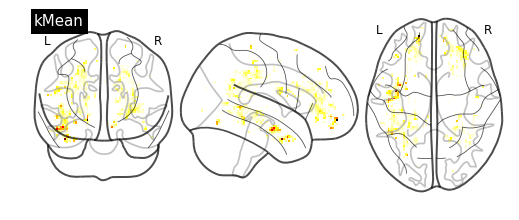

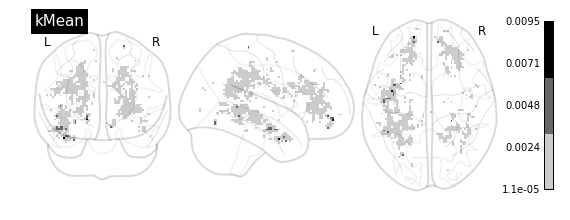

In [52]:
reload(epi_prediction)

title='kMean'
epi_prediction.plot_coeffs(coeffs, white_matter._mask_image.get_affine(), title)
epi_prediction.plot_bw_coeffs(coeffs, white_matter._mask_image.get_affine(), title)
epi_prediction.plot_bw_coeffs(coeffs, white_matter._mask_image.get_affine(), title, 
                           output_file=title+'_bw')

#plt.hist((coeffs/np.max(coeffs)).flatten());
#plt.show()
#for r in np.arange(0, 1, .1):
#    print "%s by %s" % (r, np.sum(coeffs > r))

In [19]:
np.sum(coeffs_normalized > 0)

1681

##Generate Linear Confusion Matrix

In [20]:
cv_info_lin, cv_info_train_lin = epi_prediction.verbose_cv(mat, labels_arr, anova_svc_lin, n_folds=6, verbose=False)

####
####
####
####
####
####


In [21]:
cv_info_lin.avg_precision()

0.7678571428571429

In [22]:
cv_info_lin.avg_recall()

0.74444444444444446

In [23]:
cv_info_lin.expected_mat

[array([1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0]),
 array([1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0]),
 array([1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0]),
 array([1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0]),
 array([1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0]),
 array([1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0])]

In [24]:
from sklearn.metrics import confusion_matrix

confusion_matrix(cv_info_lin.expected_mat[0], cv_info_lin.predicted_mat[0])

array([[6, 0],
       [2, 4]])

In [25]:
cv_info_lin.confusion_matrix()

array([[30,  6],
       [ 8, 24]])

In [26]:
cv_info_lin.normalized_confusion_matrix()

array([[ 0.83333333,  0.16666667],
       [ 0.25      ,  0.75      ]])

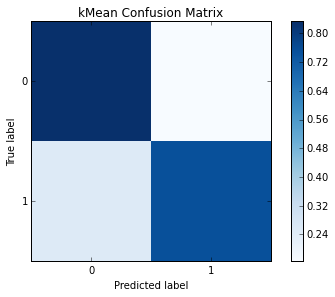

In [27]:
epi_prediction.plot_confusion_matrix(cv_info_lin.normalized_confusion_matrix(), "kMean Confusion Matrix")

In [28]:
cv_info_lin.avg_f1_score()

0.74298756798756793

In [29]:
cv_info_lin.avg_sensitivity_score()

0.74444444444444446

In [30]:
cv_info_lin.avg_specificity_score()

0.83333333333333337

### Normalize Matrix Z-score

In [28]:
from scipy.stats.mstats import zscore

X = mat.copy()
for col in xrange(X.shape[1]):
    if col % 50000 == 0:
        print '{} columns fin.'.format(col)
    X[:,col] = zscore(X[:,col]) 
    X[:,col] = X[:,col] / np.sqrt( sum( [ x**2 for x in X[:,col] ] ) )

0 columns fin.
50000 columns fin.
100000 columns fin.


In [29]:
mat.shape

(68, 134263)

<b><h3> Grid Search params := ( $k_{best}$,C ,$T_{mask}$, norm= (True || False) ) </h3></b>

In [30]:
print mat.shape

(68, 134263)


In [31]:
mat_normalized = X

In [32]:
grid_lin_normalized = GridSearchCV(anova_svc_lin, param_grid={"svc__C": C_range_lin}, cv=cv, scoring = scorer)
grid_lin_normalized.fit(mat_normalized, labels_arr)

####

//anaconda/lib/python2.7/site-packages/sklearn/feature_selection/univariate_selection.py:111: UserWarning: Features [102689] are constant.
  UserWarning)
//anaconda/lib/python2.7/site-packages/sklearn/feature_selection/univariate_selection.py:111: UserWarning: Features [87575 93929] are constant.
  UserWarning)


######################################

GridSearchCV(cv=sklearn.cross_validation.StratifiedKFold(labels=[1 1 ..., 0 0], n_folds=6, shuffle=False, random_state=None),
       error_score='raise',
       estimator=Pipeline(steps=[('anova', SelectKBest(k=500, score_func=<function f_classif at 0x10c3e2050>)), ('svc', SVC(C=1, cache_size=200, class_weight=None, coef0=0.0, degree=3, gamma=0.0,
  kernel='linear', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False))]),
       fit_params={}, iid=True, loss_func=None, n_jobs=1,
       param_grid={'svc__C': array([  1.00000e-03,   1.00000e-02,   1.00000e-01,   1.00000e+00,
         1.00000e+01,   1.00000e+02,   1.00000e+03])},
       pre_dispatch='2*n_jobs', refit=True, score_func=None,
       scoring=make_scorer(verbose_score_fn), verbose=0)

In [33]:
grid_lin_normalized.grid_scores_

[mean: 0.00000, std: 0.00000, params: {'svc__C': 0.001},
 mean: 0.70432, std: 0.20210, params: {'svc__C': 0.01},
 mean: 0.71315, std: 0.18574, params: {'svc__C': 0.10000000000000001},
 mean: 0.72475, std: 0.22658, params: {'svc__C': 1.0},
 mean: 0.73484, std: 0.23080, params: {'svc__C': 10.0},
 mean: 0.73484, std: 0.23080, params: {'svc__C': 100.0},
 mean: 0.73484, std: 0.23080, params: {'svc__C': 1000.0}]

### White Matter Threshold

In [34]:
all_fs = mod_paths['pats'] + mod_paths['cons']

In [35]:
import sys

import nilearn as nil

wm_image = nib.load('masks/white.nii')

def verbose_load(f):
    sys.stdout.write('#')
    return nil.image.resample_img(f, 
                                  target_shape=wm_image.shape, 
                                  target_affine=wm_image.get_affine())

print('-' * len(all_fs))
    
all_data = np.vstack([verbose_load(f).get_data().flatten() for f in all_fs])

--------------------------------------------------------------------
####################################################################

In [36]:
all_data.shape

(68, 902629)

In [96]:
reload(epi_prediction)
white_matter_pipe = epi_prediction.SimpleMaskerPipeline(threshold=0)

In [97]:
normalizer = epi_prediction.NormalizerPipeline(normalize_flag=False)

In [98]:
wm_norm_anova_svc = Pipeline( [('masker', white_matter_pipe),
                              ('anova', SelectKBest(k=500)), 
                              ('svc', svc)] )

In [101]:
param_grid={"svc__C": [.01, .1, 1, 10, 100],
            "masker__threshold" :[.2, .5, .7, .9],
            "anova__k": [50, 250, 500]
           }

print("-" * 2 * 5  * 2 * 4 * 2 * 3)
grid_lin = GridSearchCV(wm_norm_anova_svc, param_grid=param_grid, cv=cv, scoring = scorer)
grid_lin.fit(all_data, labels_arr)

------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
########################################################################################################################################################################################################################################################################################################################################################################

GridSearchCV(cv=sklearn.cross_validation.StratifiedKFold(labels=[1 1 ..., 0 0], n_folds=6, shuffle=False, random_state=None),
       error_score='raise',
       estimator=Pipeline(steps=[('masker', SimpleMaskerPipeline(threshold=0)), ('anova', SelectKBest(k=500, score_func=<function f_classif at 0x10c3e2050>)), ('svc', SVC(C=1, cache_size=200, class_weight=None, coef0=0.0, degree=3, gamma=0.0,
  kernel='linear', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False))]),
       fit_params={}, iid=True, loss_func=None, n_jobs=1,
       param_grid={'masker__threshold': [0.2, 0.5, 0.7, 0.9], 'anova__k': [50, 250, 500], 'svc__C': [0.01, 0.1, 1, 10, 100]},
       pre_dispatch='2*n_jobs', refit=True, score_func=None,
       scoring=make_scorer(verbose_score_fn), verbose=0)

In [102]:
grid_lin.grid_scores_

[mean: 0.00000, std: 0.00000, params: {'masker__threshold': 0.2, 'anova__k': 50, 'svc__C': 0.01},
 mean: 0.70406, std: 0.21748, params: {'masker__threshold': 0.2, 'anova__k': 50, 'svc__C': 0.1},
 mean: 0.70504, std: 0.22074, params: {'masker__threshold': 0.2, 'anova__k': 50, 'svc__C': 1},
 mean: 0.70172, std: 0.22135, params: {'masker__threshold': 0.2, 'anova__k': 50, 'svc__C': 10},
 mean: 0.71658, std: 0.18739, params: {'masker__threshold': 0.2, 'anova__k': 50, 'svc__C': 100},
 mean: 0.00000, std: 0.00000, params: {'masker__threshold': 0.5, 'anova__k': 50, 'svc__C': 0.01},
 mean: 0.70406, std: 0.21748, params: {'masker__threshold': 0.5, 'anova__k': 50, 'svc__C': 0.1},
 mean: 0.68151, std: 0.21644, params: {'masker__threshold': 0.5, 'anova__k': 50, 'svc__C': 1},
 mean: 0.67574, std: 0.21838, params: {'masker__threshold': 0.5, 'anova__k': 50, 'svc__C': 10},
 mean: 0.71818, std: 0.18739, params: {'masker__threshold': 0.5, 'anova__k': 50, 'svc__C': 100},
 mean: 0.00000, std: 0.00000, para

In [103]:
grid_lin.best_score_

0.78959276018099545

In [106]:
grid_lin.best_params_

{'anova__k': 50, 'masker__threshold': 0.9, 'svc__C': 100}